In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import mne
import scipy.signal as signal



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.svm import SVC  # SVM classifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
file = pd.read_csv(r"D:\Clg\Project\SDP 2\dataset\16\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001_sleepscoring.txt")

# print(file.shape[0])
# print(file.head())
print(file.columns)
print(file[" Annotation"][0])

print(file[' Annotation'].unique())


Index(['Date', ' Time', ' Recording onset', ' Duration', ' Annotation',
       ' Linked channel'],
      dtype='object')
 Sleep stage W
[' Sleep stage W' ' Lights off' ' Sleep stage N1' ' Sleep stage N2'
 ' Sleep stage N3' ' Sleep stage R' ' Lights on']


In [6]:
text_files = []
edf_files = []
target_map = {'W' : 1, 'N1' : 2, 'N2' : 3, 'N3' : 4, 'R' : 5}
no_of_files = 1

path = r"D:\Clg\Project\SDP 2\dataset\16\physionet.org\files\hmc-sleep-staging\1.0.0\recordings"

for i in range(1, no_of_files+1):
    text_file_name = f"\SN00{i}_sleepscoring.txt"
    edf_file_name = f"\SN00{i}.edf"

    txt_file = pd.read_csv(path + text_file_name)
    text_files.append(txt_file)

    edf_file = mne.io.read_raw_edf(path + edf_file_name, preload= True)
    
    edf_file = edf_file.pick(['EEG C4-M1'])

    time = edf_file.times[-1] - 150
    s, e = 0 + 150, 30 + 150
    idx = 0 + 5

    dic = {}

    while e < time and idx < txt_file.shape[0]:
        stage = txt_file[" Annotation"][idx].split(" ")[-1]

        if stage in target_map:
            dic[s] = [edf_file.copy().crop(tmin=s, tmax=e), stage]
        idx += 1
        s = e
        e += 30

    edf_files.append(dic)

print(len(text_files))

Extracting EDF parameters from D:\Clg\Project\SDP 2\dataset\16\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\R MOHANAKRISHNAA\AppData\Local\Temp\ipykernel_14880\470614150.py:15: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  edf_file = mne.io.read_raw_edf(path + edf_file_name, preload= True)
C:\Users\R MOHANAKRISHNAA\AppData\Local\Temp\ipykernel_14880\470614150.py:15: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  edf_file = mne.io.read_raw_edf(path + edf_file_name, preload= True)


1


Delta band extraction

In [18]:
mne.set_log_level("warning")

def _filter(_signal):
    delta_band = _signal.copy().filter(0.5, 4, fir_design='firwin')
    return delta_band

bands = _filter(dic[150][0])
print(bands[0])
for band in bands:
    temp = band.get_data()[0]

    print(temp, len(temp), '\n')

(array([[-2.22346149e-21,  9.49938352e-08,  1.91689710e-07, ...,
         7.30107848e-07,  3.67196564e-07, -3.70576914e-22]]), array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       2.99921875e+01, 2.99960938e+01, 3.00000000e+01]))


AttributeError: 'tuple' object has no attribute 'get_data'

In [8]:
# target_map = {'N1' : }


delta_band , target, delta_band_3d, target_3d = [], [], [], []

for i in range(len(edf_files)): 
    dic = edf_files[i]
    for idx, val in dic.items():

        temp = _filter(val[0])
        
        delta_band_3d.append([temp[0][0][0], temp[0][1]])
        
        if idx == 150:
            print(temp[0])
            print(temp[0][0])
            print()
        
        delta_band.append(temp[0][0][0])
        delta_band.append(temp[0][1])
        target.append(target_map[val[1]])
        target.append(target_map[val[1]])
        target_3d.append(target_map[val[1]])
# print(target)



(array([[-2.22346149e-21,  9.49938352e-08,  1.91689710e-07, ...,
         7.30107848e-07,  3.67196564e-07, -3.70576914e-22]]), array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       2.99921875e+01, 2.99960938e+01, 3.00000000e+01]))
[[-2.22346149e-21  9.49938352e-08  1.91689710e-07 ...  7.30107848e-07
   3.67196564e-07 -3.70576914e-22]]



In [9]:
# ! pip install tenserflow

LSTM model

EDA

In [10]:
delta_band_3d = np.array(delta_band_3d)
delta_band = np.array(delta_band)
target = np.array(target)
target_3d = np.array(target_3d)

print(delta_band.shape)
print(target.shape)
print(delta_band_3d.shape)
print(target_3d.shape)

print(np.min(delta_band_3d))
print(np.max(delta_band_3d))


flattened_array = delta_band_3d.flatten()

# Define the ranges
range1_lower, range1_upper = -1, 4
range2_lower, range2_upper = 5, 10
range3_lower, range3_upper = 10, 30

# Count the number of elements in each range
count_range1 = np.sum((flattened_array >= range1_lower) & (flattened_array <= range1_upper))
count_range2 = np.sum((flattened_array >= range2_lower) & (flattened_array <= range2_upper))
count_range3 = np.sum((flattened_array >= range3_lower) & (flattened_array <= range3_upper))

print(f"Number of values between {range1_lower} and {range1_upper}: {count_range1}")
print(f"Number of values between {range2_lower} and {range2_upper}: {count_range2}")
print(f"Number of values between {range3_lower} and {range3_upper}: {count_range3}")

(1688, 7681)
(1688,)
(844, 2, 7681)
(844,)
-0.0009147727161124097
30.0
Number of values between -1 and 4: 7347864
Number of values between 5 and 10: 1081164
Number of values between 10 and 30: 4322124


Normalization

In [11]:
mean = np.mean(delta_band_3d)
std = np.std(delta_band_3d)

# Z-score normalization
z_normalized = (delta_band_3d - mean) / std

print(z_normalized)

[[[-0.77455633 -0.77455632 -0.77455631 ... -0.77455625 -0.77455629
   -0.77455633]
  [-0.77455633 -0.77415291 -0.7737495  ...  2.32286216  2.32326557
    2.32366899]]

 [[-0.77455633 -0.77455623 -0.77455613 ... -0.77455651 -0.77455642
   -0.77455633]
  [-0.77455633 -0.77415291 -0.7737495  ...  2.32286216  2.32326557
    2.32366899]]

 [[-0.77455633 -0.77455644 -0.77455654 ... -0.77455641 -0.77455637
   -0.77455633]
  [-0.77455633 -0.77415291 -0.7737495  ...  2.32286216  2.32326557
    2.32366899]]

 ...

 [[-0.77455633 -0.77455644 -0.77455654 ... -0.77455654 -0.77455644
   -0.77455633]
  [-0.77455633 -0.77415291 -0.7737495  ...  2.32286216  2.32326557
    2.32366899]]

 [[-0.77455633 -0.77455648 -0.77455662 ... -0.77455646 -0.77455639
   -0.77455633]
  [-0.77455633 -0.77415291 -0.7737495  ...  2.32286216  2.32326557
    2.32366899]]

 [[-0.77455633 -0.77455636 -0.77455639 ... -0.77455655 -0.77455644
   -0.77455633]
  [-0.77455633 -0.77415291 -0.7737495  ...  2.32286216  2.32326557
    

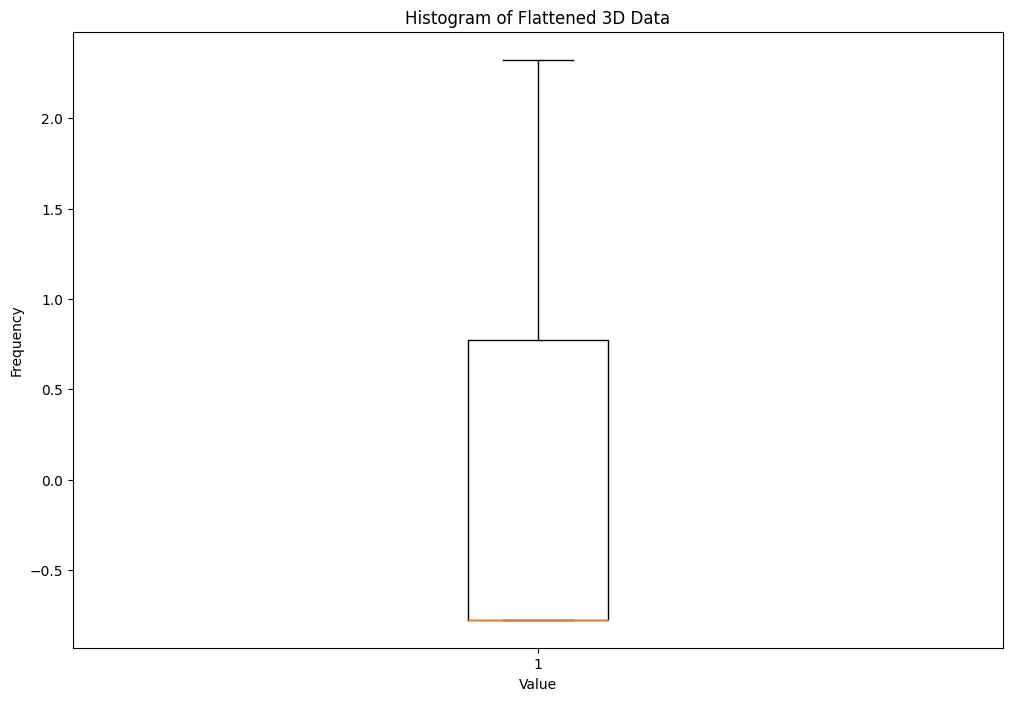

In [12]:
# Assuming delta_band_3d is a 3D numpy array
z_normalized_flattened = z_normalized.flatten()

plt.figure(figsize=(12, 8))
plt.boxplot(z_normalized_flattened)  # You can adjust the number of bins
plt.title('Histogram of Flattened 3D Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(z_normalized, target_3d, test_size=0.2, random_state=42)

print(X_test.shape, X_train.shape)
print(y_test.shape, y_train.shape)


# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

# Making predictions
predictions = model.predict(X_test)

# Example output
print(f'\nExample Predictions: {predictions[:5]}')


(169, 2, 7681) (675, 2, 7681)
(169,) (675,)
Epoch 1/10
22/22 [==============================] - 4s 58ms/step - loss: -788.4587 - accuracy: 0.1585 - val_loss: -1770.1635 - val_accuracy: 0.2012
Epoch 2/10
22/22 [==============================] - 1s 36ms/step - loss: -3300.6707 - accuracy: 0.1585 - val_loss: -4791.4990 - val_accuracy: 0.2012
Epoch 3/10
22/22 [==============================] - 1s 36ms/step - loss: -7507.7568 - accuracy: 0.1585 - val_loss: -9870.8447 - val_accuracy: 0.2012
Epoch 4/10
22/22 [==============================] - 1s 34ms/step - loss: -14432.8477 - accuracy: 0.1585 - val_loss: -17902.8848 - val_accuracy: 0.2012
Epoch 5/10
22/22 [==============================] - 1s 32ms/step - loss: -25021.1680 - accuracy: 0.1585 - val_loss: -30018.8145 - val_accuracy: 0.2012
Epoch 6/10
22/22 [==============================] - 1s 32ms/step - loss: -40767.6641 - accuracy: 0.1585 - val_loss: -47305.3828 - val_accuracy: 0.2012
Epoch 7/10
22/22 [==============================] - 1s 33

SVR model

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(delta_band, target, test_size=0.2, random_state=42)

# Create and train the SVM model (linear kernel)
model = SVC(kernel='linear')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Accuracy: 51.18%
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        54
           3       0.51      1.00      0.68       173
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        45

    accuracy                           0.51       338
   macro avg       0.10      0.20      0.14       338
weighted avg       0.26      0.51      0.35       338



C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Load dataset (Iris dataset as an example)
data = load_iris()
X = data.data  # Features
y = data.target  # Target (classes)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(delta_band, target, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Feature importance
importances = clf.feature_importances_
print(f'Feature Importances: {importances}')


Accuracy: 51.18%
Feature Importances: [0.00000000e+00 2.26721542e-05 1.62228080e-04 ... 2.36516692e-04
 1.98012297e-04 0.00000000e+00]
